<a href="https://colab.research.google.com/github/ADiti16Sengar/DL-CHE/blob/main/Feature_Importance/Feature_Selection_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing packages
import numpy as np # for array related operations
import pandas as pd # to read csv
import matplotlib.pyplot as plt # for visualisation
import seaborn as sns # for visualisation

# ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:

data = pd.read_csv('AdsorptionData.csv')
data.head()

,C(x1),H(x2),N(x3),Si(x4),BET(x5),Adorption Capacity(output)
0,12.8,1.16,0.38,7.51,8.75,0.144
1,6.5,0.57,0.04,3.34,3.69,0.334
2,8.7,0.54,0.21,40.98,33.37,0.452
3,3.5,0.35,0.12,22.05,7.55,0.333
4,7.2,0.71,0.03,3.16,1.97,0.383


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   C(x1)                       35 non-null     float64
 1   H(x2)                       35 non-null     float64
 2   N(x3)                       35 non-null     float64
 3   Si(x4)                      35 non-null     float64
 4   BET(x5)                     35 non-null     float64
 5   Adorption Capacity(output)  35 non-null     float64
dtypes: float64(6)
memory usage: 1.8 KB


<Axes: >

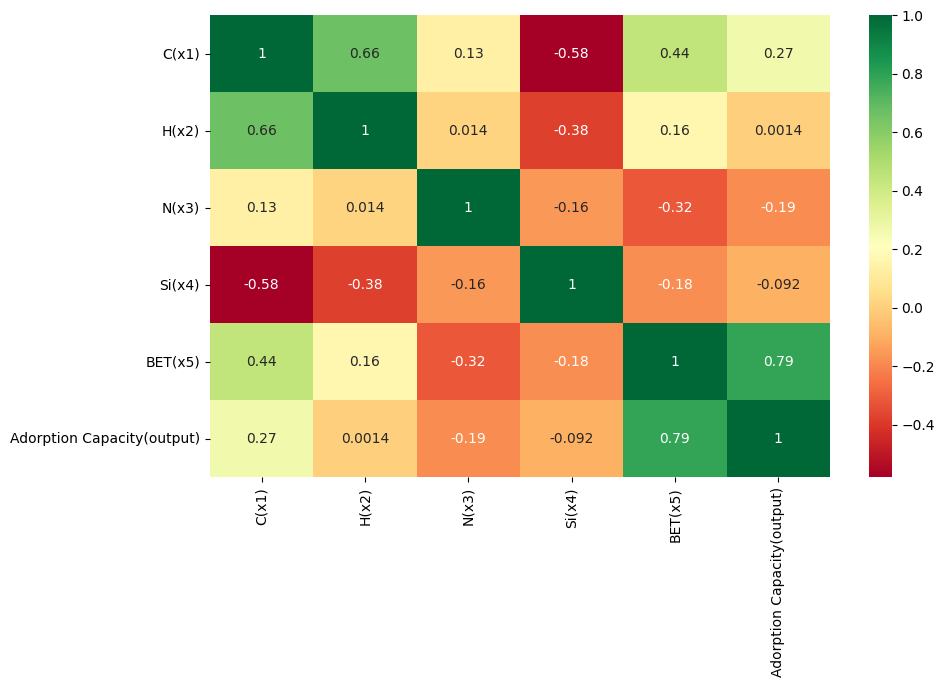

In [5]:
#get correlations of each features in dataset
corrmat = data.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corrmat, annot=True, cmap="RdYlGn")

In [6]:
# Splitting data into Input and Target Variable

y = data[['Adorption Capacity(output)']]  # target variable i.e diabetic or not
X = data.drop(['Adorption Capacity(output)'], axis=1)  # input variables

In [7]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=1)

In [10]:
# Building the Logistic Regression model
from sklearn.linear_model import LinearRegression



In [12]:
clf_lr = LinearRegression()
lr_baseline_model = clf_lr.fit(X_train,y_train)

In [16]:
# Noting down accuracy of the baseline model
from sklearn.metrics import mean_squared_error

# finding our predicted values
y_pred = lr_baseline_model.predict(X_test)


In [17]:
mse = mean_squared_error(y_test, y_pred)

print(" Model mean_squared_error:", mse)

Baseline Model mean_squared_error: 33.03607249562852


### Applying RFE

In [18]:
from sklearn.feature_selection import RFE #importing RFE class from sklearn library

rfe = RFE(estimator= clf_lr , step = 1)
# estimator clf_lr is the baseline model (basic model) that we have created under "Base line Model" selection
# step = 1: removes one feature at a time and then builds a model on the remaining features
# It uses the model accuracy to identify which features (and combination of features) contribute the most to predicting the target variable.
# we can even provide no. of features as an argument

# Fit the function for ranking the features
fit = rfe.fit(X_train, y_train)

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 2
Selected Features: [False  True  True False False]
Feature Ranking: [2 1 1 4 3]


In [19]:
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
                                      'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
1,H(x2),1
2,N(x3),1
0,C(x1),2
4,BET(x5),3
3,Si(x4),4


In [20]:
# Transforming the data
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fitting our baseline model with the transformed data
lr_rfe_model = clf_lr.fit(X_train_rfe, y_train)

### Comparison of model performance with and without feature selection

In [23]:
# making predictions and evaluating the model
y_pred_rfe = lr_rfe_model.predict(X_test_rfe)

rfe_mean_squared_error = mean_squared_error(y_test, y_pred_rfe)


print("RFE mean_squared_error:", rfe_mean_squared_error)


RFE mean_squared_error: 9.730670594272066


We can see an improvement in both accuracy and F1 score as oppose to the baseline model (clf_lr) where we didn't apply feature selection

## 2. Feature Importance using Random Forest

Feature importance is another feature selection technique used to select features. It gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Bagged decision trees models like Random Forest can be used to estimate the importance of features.



### Train a Random Forest Classifier (Baseline Model)

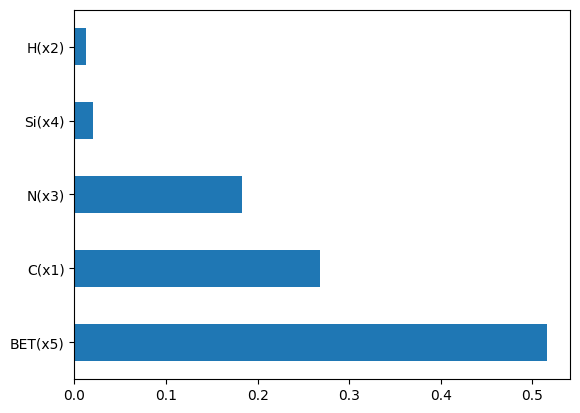

In [25]:
from sklearn.ensemble import RandomForestRegressor

rf_clf = RandomForestRegressor(n_estimators=10000, random_state=1, n_jobs=-1)
rf_clf.fit(X_train, y_train)
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [26]:
from sklearn.feature_selection import SelectFromModel
rf_sfm = SelectFromModel(rf_clf)
rf_sfm = rf_sfm.fit(X_train, y_train)

### Create a new subset of the data with only the selected features

In [27]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = rf_sfm.transform(X_train)
X_important_test = rf_sfm.transform(X_test)

### Train a new Random Forest Classifier using selected important features

In [29]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestRegressor(n_estimators=10000, random_state=1, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important = clf_important.fit(X_important_train, y_train)

### Comparison of model performance with and without feature selection

In [30]:
y_pred = rf_clf.predict(X_test)
rf_ac = mean_squared_error(y_test, y_pred)


# View The Accuracy Of Our Full Feature (8 Features) Model
print("Baseline Model Accuracy:", rf_ac)


Baseline Model Accuracy: 11.932679108119757


In [31]:

y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature (4 Features) Model
rf_imp_ac = mean_squared_error(y_test, y_important_pred)
print("Limited Features Model Accuracy:", rf_imp_ac)


Limited Features Model Accuracy: 12.750186137867585
